In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats
from scipy import fftpack
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

数据读取

In [2]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test_data.csv')

提取标签

In [3]:
y_train = pd.DataFrame()
y_train['label'] = df_train['label']
df_train.drop(columns='label',inplace=True)

定义特征提取函数

In [4]:
def get_t(df):
    mean_list = []
    std_list = []
    var_list = []
    min_list = []
    max_list = []
    median_list = []
    skew_list = []
    kuri_list = []
    iqr_list = []
    rms_list = []
    ff_list = []
    par_list = []
    maichong_list = []
    ppv_list =[]
    energy_list = []
    x = pd.DataFrame()
    for i in range(len(df)):
        mean_list.append(np.mean(df.iloc[i][1:].values))#均值
        std_list.append(np.std(df.iloc[i][1:].values))#标准差
        var_list.append(np.var(df.iloc[i][1:].values))#方差
        min_list.append(np.min(df.iloc[i][1:].values))#最小值
        max_list.append(np.max(df.iloc[i][1:].values))#最大值
        median_list.append(np.median(df.iloc[i][1:].values))#中值
        skew_list.append(stats.skew(df.iloc[i][1:].values))#偏度
        kuri_list.append(stats.kurtosis(df.iloc[i][1:].values))#峰度
        lower_q=np.quantile(df.iloc[i][1:].values,0.25,interpolation='lower')#四分位间距
        higher_q=np.quantile(df.iloc[i][1:].values,0.75,interpolation='higher')
        iqr_list.append(higher_q - lower_q)
        df_mean = np.mean(df.loc[i][1:].values)#均方根
        df_std = np.std(df.iloc[i][1:].values)
        rms_list.append(math.sqrt(pow(df_mean,2) + pow(df_std,2)))
        df_rms = math.sqrt(pow(df_mean,2) + pow(df_std,2))#波形因子
        ff_list.append(df_rms / (abs(df.iloc[i][1:].values).mean()))
        par_list.append((max(df.iloc[i][1:].values)) / df_rms)#峰值因子
        maichong_list.append((max(df.iloc[i][1:].values)) / (abs(df.iloc[i][1:].values).mean()))#脉冲因子
        ppv_list.append(np.max(df.iloc[i][1:].values)-np.min(df.iloc[i][1:].values))#峰峰值
        fft_y = fftpack.fft(df.iloc[i][1:].values)#能量
        abs_y = np.abs(fft_y)
        normalization_y=abs_y/6000
        normalization_half_y = normalization_y[range(int(6000/2))]
        energy_list.append(sum([y * y for y in normalization_half_y]))
    x['mean'] = mean_list
    x['std'] = std_list
    x['var'] = var_list
    x['min'] = min_list
    x['max'] = max_list
    x['median'] = median_list
    x['skew'] = skew_list
    x['kuri'] = kuri_list
    x['iqr'] = iqr_list
    x['rms'] = rms_list
    x['ff'] = ff_list
    x['par'] = par_list
    x['maichong'] = maichong_list
    x['ppv'] = ppv_list
    x['energy'] = energy_list
    return x

特征提取

In [5]:
x_train = get_t(df_train)
x_test = get_t(df_test)

定义函数输出测试集结果

In [6]:
def to_file(label,df_test):
    """
    将预测输出成csv文件
    """
    result = pd.DataFrame()
    result['id'] = df_test['id']
    result['label'] = label
    result.to_csv('result_MLP.csv',index = False,encoding = "utf-8")

模型训练

In [7]:
model = MLPClassifier(activation = 'tanh',
                    hidden_layer_sizes = (100),
                    max_iter = 800,batch_size = 10)
                    
scores = cross_val_score(model,x_train, y_train.values.reshape(len(y_train)), cv=5)
print(scores)
print(scores.mean())

[0.95597484 0.98113208 0.98734177 0.96202532 0.97468354]
0.9722315102300773


In [11]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
X = x_train.values
Y = y_train.values.reshape(len(y_train))
acc = []
f1 = []
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    model.fit(X_train,Y_train)
    pred = model.predict(X_test)
    a = f1_score(Y_test,pred, average='macro')
    print(a)
    f1.append(a)
    acc_score = accuracy_score(Y_test,pred)
    print(acc_score)
    acc.append(acc_score)
mean_acc = np.mean(acc)
print('acc mean:',mean_acc)
mean_f1  = np.mean(f1)
print('f1 mean:',mean_f1)

0.9251878023936848
0.9559748427672956
0.956388888888889
0.9748427672955975
0.9882352941176471
0.9936708860759493
0.9282456140350878
0.9556962025316456
0.9739023695602643
0.9810126582278481
acc mean: 0.9722394713796672
f1 mean: 0.9543919937991145


In [12]:
rst = model.predict(x_test)
#to_file(rst, df_test)

混淆矩阵

In [18]:
x_tra,x_val,y_tra,y_val = train_test_split(x_train,y_train.values.reshape(len(y_train)),test_size = 0.2)
model.fit(x_tra,y_tra)
y_pred = model.predict(x_val)

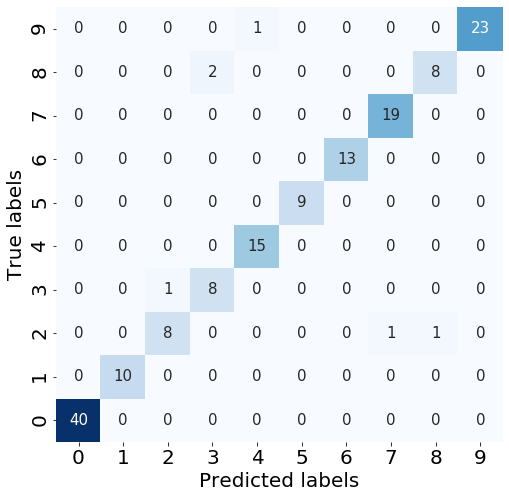

In [19]:
con_mat = confusion_matrix(y_val,y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat, annot=True, cmap='Blues',cbar=False, annot_kws={'size':15})

plt.ylim(0, 10)
plt.xlabel('Predicted labels',fontsize=20)
plt.ylabel('True labels',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

f1 score

In [20]:
p = precision_score(y_val, y_pred, average='macro')
r = recall_score(y_val, y_pred, average='macro')
print('Precision:{};recall:{}'.format(p,r))
a = f1_score(y_val,model.predict(x_val), average='macro')
f1_result = math.sqrt(a)
print(a)
print(f1_result)

Precision:0.9465277777777779;recall:0.9447222222222222
0.9447140103571849
0.9719639964305185


特征重要性